
# Comparative performance of shrimp models

## Notebook Summary

This notebook is developed from the New Atlantis XGBoost Template. We run several models for total shrimp mass and compare their relative performances.

## Models

### XGBoost: Key Properties and Design

XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting machines. Key properties include:

- Ensemble learning method using decision trees
- Sequential building of weak learners to create a strong predictor
- Optimized for speed and performance
- Handles missing data automatically
- Built-in regularization to prevent overfitting
- Supports both regression and classification tasks


### HistGradientBoost

Another useful model is Histogram Gradient Boosting, which is a modified Gradient Boosting algorithm that enhances speed and efficiency. The key difference between this model and standard gradient boosting is that continuous features are divided into discrete bins (histograms), which
reduces the number of unique feature values. Like XGBoost, this model can handle missingness effectively.




In [ ]:
# Install necessary libraries
!pip install shap

# Import necessary libraries
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV

# Un-comment once libs installing clean
# clear_output()

# Check XGBoost version
print(f"XGBoost version: {xgb.__version__}")

# Check other library versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"SHAP version: {shap.__version__}")

# Set up plotting styles
# plt.style.use('seaborn')
# sns.set_palette("viridis")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.2 MB/s eta 0:00:00
XGBoost version: 2.1.1
NumPy version: 1.26.4
Pandas version: 2.1.4
Scikit-learn version: 1.3.2
SHAP version: 0.46.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/SHRIMP_constant_gear.csv')

In [ ]:


# Preprocess the data
def preprocess_data(df):


    # Drop irrelevant columns
    df = df.drop(['MILITARY_TIME_STR', 'TEMP_SSURF','HAULVALUE', 'TIME_MIL'],  axis=1)  # Add this line
    return df

# Preprocess and display the dataframe
df = preprocess_data(df)
df.head()

,STATIONID,DEPTH_EMAX,TEMPSURF,TEMPMID,SALSURF,SALMID,SALMAX,OXYSURF,OXYMID,OXYMAX,...,CNT_PF,CNT_WM,CNT_WF,GEAR_SIZE,GEAR_TYPE,MESH_SIZE,MIN_FISH,TOTAL_SHRIMP_COUNT,TOTAL_SHRIMP_WEIGHT,MINUTES_SINCE_MIDNIGHT
0,504,14.0,24.98,22.41,29.65,34.76,35.01,4.6,4.4,4.1,...,0.0,0.0,0.0,40.0,ST,1.63,15.0,2.0,0.030,523
1,505,13.0,25.96,24.79,21.12,30.96,34.57,7.6,5.3,0.8,...,0.0,0.0,0.0,40.0,ST,1.63,18.0,1.0,0.005,670
2,508,34.0,27.72,23.02,27.95,36.02,36.14,6.6,4.7,4.9,...,1.0,0.0,0.0,40.0,ST,1.63,42.0,2.0,0.020,982
3,509,27.0,26.93,23.30,25.23,35.38,36.14,6.9,6.5,5.0,...,1.0,0.0,0.0,40.0,ST,1.63,10.0,1.0,0.010,1185
4,510,24.0,26.53,23.50,25.46,34.89,36.11,6.8,6.8,4.6,...,50.0,0.0,0.0,40.0,ST,1.63,44.0,107.0,3.006,1228


XGB Mean Squared Error: 1.6098723447861616
HGB Mean Squared Error: 1.3901438241851727
XGB Feature Importances:
DEPTH_EMAX: 0.046489130705595016
TEMPSURF: 0.061783794313669205
TEMPMID: 0.03695198893547058
SALSURF: 0.031442008912563324
SALMAX: 0.06154248118400574
OXYSURF: 0.01883024349808693
OXYMID: 0.020042063668370247
OXYMAX: 0.058110758662223816
CHLORSURF: 0.048938360065221786
CHLORMID: 0.05977749824523926
CHLORMAX: 0.04459550231695175
TEMP_BOT: 0.09258776903152466
DECSLAT: 0.04318532720208168
DECSLON: 0.12107530981302261
YEAR: 0.10285593569278717
DAYOFYEAR: 0.05017498880624771
MINUTES_SINCE_MIDNIGHT: 0.10161683708429337


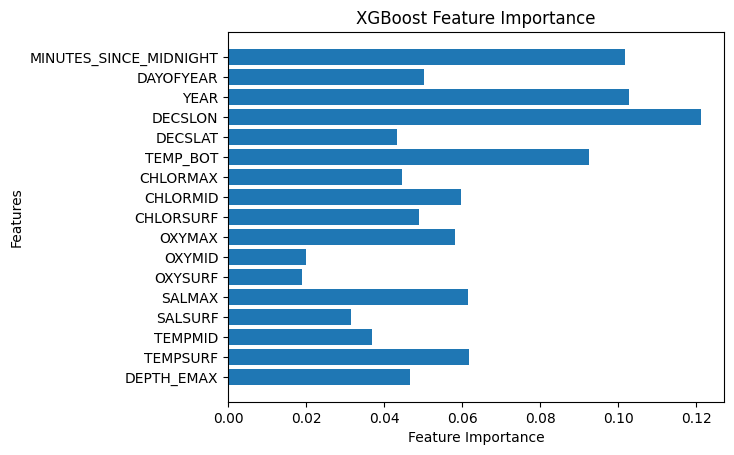

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(df):
  X= df[['DEPTH_EMAX',
              'TEMPSURF',
              'TEMPMID',
              'SALSURF',
              'SALMAX',
              'OXYSURF',
              'OXYMID',
              'OXYMAX',
              'CHLORSURF',
              'CHLORMID',
              'CHLORMAX',
              'TEMP_BOT',
              'DECSLAT',
              'DECSLON',
              'YEAR',
              'DAYOFYEAR',
              'MINUTES_SINCE_MIDNIGHT']]
  y = df['TOTAL_SHRIMP_WEIGHT']

  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=216)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(df)

# Create a copy of X_train and insert y_train as a new column
X_tt = X_train.copy()
X_tt["TOTAL_SHRIMP_WEIGHT"] = y_train

# Now split the combined data again
X_tt, X_val, y_tt, y_val = split_data(X_tt)

# Create an XGBoost regressor
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1  # Minimum sum of instance weight needed in a child
)

#Create an HGBoost regressor

modelhgb =  HistGradientBoostingRegressor()

# Train the models
model.fit(X_tt, y_tt)
modelhgb.fit(X_tt, y_tt)

# Make predictions on the test set
y_pred = model.predict(X_val)
y_predhgb = modelhgb.predict(X_val)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, y_pred)
print(f"XGB Mean Squared Error: {mse}")
msehgb = mean_squared_error(y_val, y_predhgb)
print(f"HGB Mean Squared Error: {msehgb}")


# Explore feature importance
feature_importances = model.feature_importances_
print("XGB Feature Importances:")
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

In [ ]:
# prompt: Find the mean squared error of the baseline model which just returns the mean of the training set

# Calculate the mean of the training target values
y_tt_mean = y_tt.mean()

# Create an array of predicted values, all equal to the mean
y_pred_baseline = np.full_like(y_val, y_tt_mean)

# Calculate the mean squared error for the baseline model
mse_baseline = mean_squared_error(y_val, y_pred_baseline)
print(f'Mean Squared Error of the baseline model: {mse_baseline}')

Mean Squared Error of the baseline model: 2.4884055228466515


## Performance evaluation

Both HistGradBoostingRegressor and XGBoost outperformed the baseline model, but HistGradBoostingRegressor outperformed XGBoost (and this remained true for all choices of features that we encountered). Therefore, we will focus on HGB going forward

![SHAP Logo](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_logo.png)
## (SHapley Additive exPlanations)

SHAP is a Python library for interpreting machine learning models and explaining their predictions. It's based on game theory and provides a unified approach to explaining the output of any machine learning model.

### Key Features:

- **Model Agnostic**: Works with any machine learning model
- **Local and Global Explanations**: Provides both instance-level and model-level interpretations
- **Visualization Tools**: Offers various plots for intuitive understanding of model behavior

### Usage:

SHAP can be used to:
1. Explain individual predictions
2. Understand global model behavior
3. Identify feature importance
4. Visualize feature interactions

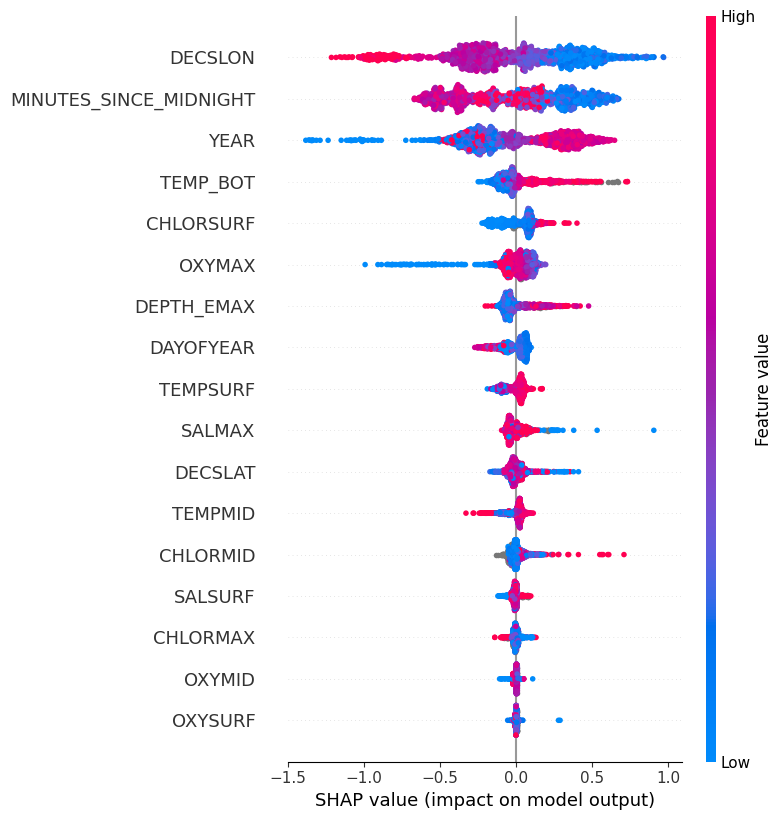

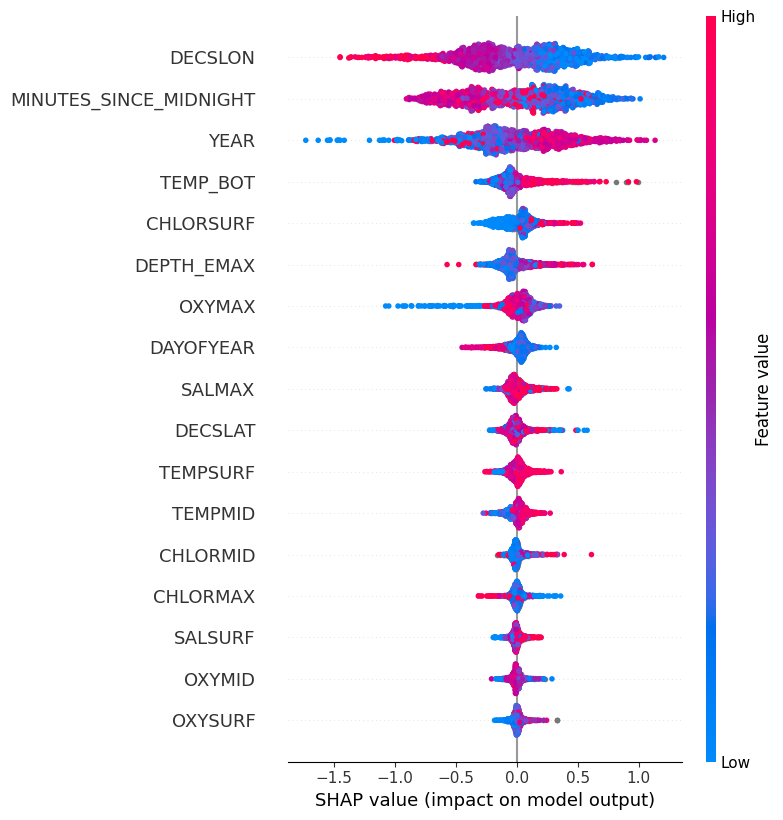

In [ ]:
# Explain the XGBoost model's predictions using SHAP
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Summarize the effects of all the features
#shap.summary_plot(shap_values, X_test)

#Explain the HGBoost model predictions with SHAP
explainerhgb = shap.TreeExplainer(modelhgb)
shap_valueshgb = explainerhgb.shap_values(X_test)

# Visualize the HGB prediction's explanation
shap.initjs()
shap.force_plot(explainerhgb.expected_value, shap_valueshgb[0,:], X_test.iloc[0,:])

# Summarize the HGB effects of all the features
shap.summary_plot(shap_valueshgb, X_test)

## Hyperparameter Tuning with Grid Search

Hyperparameter tuning is a crucial step in optimizing machine learning models. It involves finding the best combination of hyperparameters that yield the highest model performance. For XGBoost, we'll focus on tuning three key parameters: `max_depth`, `learning_rate`, and `n_estimators`.

### Key Parameters:

1. **max_depth**:
   - Controls the maximum depth of each tree in the ensemble.
   - Deeper trees can capture more complex patterns but may lead to overfitting.
   - Shallower trees are simpler and may generalize better.

2. **learning_rate** (also known as eta):
   - Scales the contribution of each tree in the ensemble.
   - Lower values make the model more robust by shrinking the contribution of each tree.
   - Higher values may lead to overfitting but can sometimes yield better performance.

3. **n_estimators**:
   - Determines the number of trees in the ensemble.
   - More trees can potentially capture more complex patterns.
   - Too many trees may lead to overfitting and increased computational cost.

### Grid Search Process:

Grid search is an exhaustive search through a manually specified subset of the hyperparameter space. Here's how it works:

1. Define a range of values for each hyperparameter.
2. Create all possible combinations of these values.
3. Train a model for each combination.
4. Evaluate each model using cross-validation.
5. Select the best performing combination.


In [ ]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 150],
    'l2_regularization': [0.0, 0.1, 0.2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=modelhgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_tt, y_tt)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Extract the best parameters from the grid search
best_params = grid_search.best_params_

#Create a model with the best parameters
best_hgb_model = HistGradientBoostingRegressor(**best_params) # Use HistGradientBoostingRegressor from the imported module

# Train the best model
best_hgb_model.fit(X_tt, y_tt)

# Make predictions on the test set
y_pred_best = best_hgb_model.predict(X_val)

# Evaluate the best model
mse_hgb_best = mean_squared_error(y_val, y_pred_best)
print(f"Mean Squared Error (Best Model): {mse_hgb_best}")

Best Parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_iter': 100}
Best Score: 1.573984345023701
Mean Squared Error (Best Model): 1.3901438241851727


In [ ]:
#Parameter tuning for XGBoost

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_tt, y_tt)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params)

# Train the best model
best_model.fit(X_tt, y_tt)

# Make predictions on the test set
y_pred_best = best_model.predict(X_val)

# Evaluate the best model
mse_best = mean_squared_error(y_val, y_pred_best)
print(f"Mean Squared Error (Best Model): {mse_best}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 220, in accuracy_scor

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mean Squared Error (Best Model): 1.691079300206069
